# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, sum
from pyspark.sql.types import IntegerType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import re
import datetime
import numpy as np
import pandas as pd

import time

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master("local[4]") \
    .appName("Sparkify_Churn_Analysis") \
    .config("spark.network.timeout","3601") \
    .config("spark.executor.heartbeatInterval","3600") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
df = spark.read.json('mini_sparkify_event_data.json')
df.createOrReplaceTempView("log_table")
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

Let's first drop duplicates.

In [5]:
df = df.dropDuplicates()

and log entries from unregistered users

In [6]:
df = spark.sql(" SELECT * FROM log_table WHERE userID != '' ")

In [7]:
df.createOrReplaceTempView("log_table")

### Adding columns for hour, date, weekday and calendar week:

In [8]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
get_date = udf(lambda x: str(datetime.datetime.fromtimestamp(x / 1000.0).date()))
get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).weekday())
get_week = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).date().isocalendar()[1])

In [9]:
df = df.withColumn("date", get_date(df.ts))
df = df.withColumn("hour", get_hour(df.ts))
df = df.withColumn("weekday", get_weekday(df.ts))
df = df.withColumn("week", get_week(df.ts))

In [10]:
df.createOrReplaceTempView("log_table")

In [13]:
ts_begin = spark.sql('SELECT MIN(ts) FROM log_table').first()[0]
ts_end = spark.sql('SELECT MAX(ts) FROM log_table').first()[0]
begin_datettime = datetime.datetime.fromtimestamp(ts_begin/1000)
end_datetime = datetime.datetime.fromtimestamp(ts_end/1000)
print('Data was collected between {} and {} over {} days.'.format(str(begin_datettime), str(end_datetime), (ts_end - ts_begin)//(24*3600000)))

Data was collected between 2018-10-01 02:01:57 and 2018-12-03 02:11:16 over 63 days.


### The suggestion was to define churn as following events:
1. Customer cancelled account.
2. Customer downgraded account.

The first case is easier to track. Since the number of cancelled auth and visits to "Cancellation Confirmation" page is same, we can assume, that after visiting the page and getting the cancelled auth the users have cancelled their accounts.

The second case is more complicated and ambiguous, because the user behaviour of someone who downgraded their account may not be different from that of a paying user.They may choose to downgrade because they don't use the service frequently or just don't have the financial ability to pay for higher level service. Also let's keep in mind that we still generate revenue from free level users by rolling ads.

### In this notebook we define churn as account cancellation.

In [11]:
get_churn_cancel = udf(lambda x: int(x=='Cancellation Confirmation'), IntegerType())
df = df.withColumn('churn_cancelled', get_churn_cancel('page'))
df.createOrReplaceTempView("log_table")

### Outliers

#### Early churn
If a user cancelled account in a timeframe less than a five days from beginning of observations we are dealing with early churn. In this case this user's data will not be compareable to others.

In [14]:
# let's find early churn users:
early_churn = spark.sql(''' SELECT userID, ts FROM log_table WHERE churn_cancelled = 1 ''').toPandas()
early_churn.sort_values('ts', inplace = True)
early_churn[early_churn['ts'] < ts_begin + 3600*24*5*1000]
early_churn = early_churn[early_churn['ts'] < ts_begin + 3600*24*5*1000]
list_remove = early_churn.userID.tolist()

#### Non-use
Some customers have very low interaction level. It is possible that they do not use the service at all. Keeping them in the analysis will skew the distribution of our features. We will assume that users with less than one interaction per day on average are effectively not using our service.

In [15]:
usage_statistic = spark.sql(''' SELECT userID, count(ts) AS interactions, MAX(churn_cancelled) AS churn FROM log_table GROUP BY userID ''').toPandas()

No handles with labels found to put in legend.


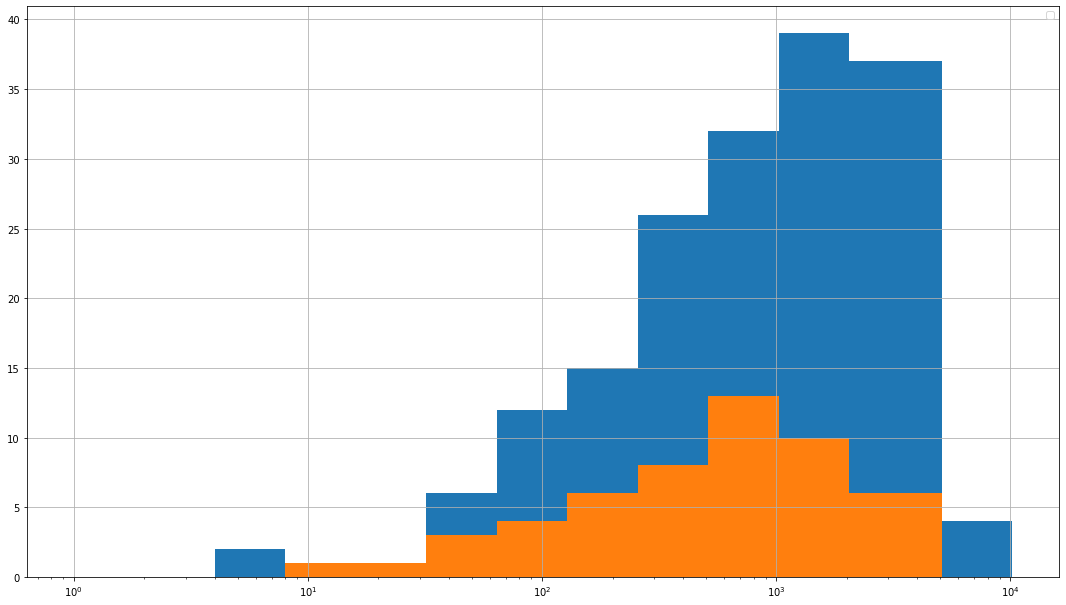

In [16]:
usage_statistic.groupby('churn')['interactions'].hist(bins = [0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 5096, 10192])
plt.xscale('log')
plt.legend()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

In [17]:
non_users = usage_statistic[usage_statistic['interactions']<60].userID.tolist()
list_remove.extend([x for x in non_users if not x in list_remove])

In [18]:
print('We will have to remove {} users from our analysis due to early churn or low number of interactions.'.format(len(list_remove)))
print('User IDs: ', ' '.join(list_remove))

We will have to remove 14 users from our analysis due to early churn or low number of interactions.
User IDs:  100011 100001 100024 300007 100006 125 133 22 90 68 135 156 300003 134


# Feature Engineering

##### Methodology
It may seem to plausible to involve such factors as browser, platform, location or gender in the prediction of churn. These factors may lead to churn, but they are affecting certain groups of customers and are not related to individual customer experience. Therefore they will not help us to predict churn, but rather indicate which customer groups may be more dissatisfied with our service.

In this analysis we will focus on user specific factors such as:
 * number of songs played
 * number of different songs played
 * number of different artists
 * number of sessions
 * number of upgrades
 * number of downgrades
 * page visits
     * downgrade
     * upgrade
     * thumbs down
     * thumbs up
     * roll advert
     * home
     * logout
     * settings
     * save settings
     * add to playlist
     * help
     * error
     * about
     * add friend

In [46]:
df_churn = spark.sql('''
SELECT userID, count(song) AS song_count, \
count(DISTINCT song) AS dist_song_count, \
count(DISTINCT artist) AS dist_artist_count, \
count(DISTINCT sessionId) AS session_count, \
count(CASE WHEN page = "Submit Downgrade" THEN 1 END) AS downgrade_count, \
count(CASE WHEN page = "Submit Upgrade" THEN 1 END) AS upgrade_count, \
count(CASE WHEN page = "Cancellation Confirmation" THEN 1 END) AS churn, \
count(CASE WHEN page = "Home" THEN 1 END) AS page_visits_home, \
count(CASE WHEN page = "Logout" THEN 1 END) AS page_visits_logout, \
count(CASE WHEN page = "Settings" THEN 1 END) AS page_visits_settings, \
count(CASE WHEN page = "Save Settings" THEN 1 END) AS page_visits_save_settings, \
count(CASE WHEN page = "Thumbs Down" THEN 1 END) AS page_visits_thumbs_down, \
count(CASE WHEN page = "Thumbs Up" THEN 1 END) AS page_visits_thumbs_up, \
count(CASE WHEN page = "Upgrade" THEN 1 END) AS page_visits_upgrade, \
count(CASE WHEN page = "Downgrade" THEN 1 END) AS page_visits_downgrade, \
count(CASE WHEN page = "Roll Advert" THEN 1 END) AS page_visits_roll_advert, \
count(CASE WHEN page = "About" THEN 1 END) AS page_visits_about, \
count(CASE WHEN page = "Add to Playlist" THEN 1 END) AS page_visits_add_to_playlist, \
count(CASE WHEN page = "Add Friend" THEN 1 END) AS page_visits_add_friend, \
count(CASE WHEN page = "Help" THEN 1 END) AS page_visits_help, \
count(CASE WHEN page = "Error" THEN 1 END) AS page_visits_error \
FROM log_table GROUP BY userID ''').toPandas()

In [47]:
# let's look at the counts
df_churn.iloc[:10,:8]

,userID,song_count,dist_song_count,dist_artist_count,session_count,downgrade_count,upgrade_count,churn
0,100010,275,269,252,7,0,0,0
1,200002,387,378,339,6,0,1,0
2,125,8,8,8,1,0,0,1
3,51,2111,1854,1385,10,0,0,1
4,124,4079,3339,2232,29,0,0,0
5,7,150,148,142,7,0,0,0
6,54,2841,2414,1744,37,1,1,1
7,15,1914,1707,1302,15,0,0,0
8,155,820,759,643,6,0,1,0
9,132,1928,1718,1299,16,0,1,0


In [48]:
# let's look at the page visits
df_churn.iloc[:10,7:]

,churn,page_visits_home,page_visits_logout,page_visits_settings,page_visits_save_settings,page_visits_thumbs_down,page_visits_thumbs_up,page_visits_upgrade,page_visits_downgrade,page_visits_roll_advert,page_visits_about,page_visits_add_to_playlist,page_visits_add_friend,page_visits_help,page_visits_error
0,0,11,5,0,0,5,17,2,0,52,1,7,4,2,0
1,0,20,5,3,0,6,21,2,5,7,3,8,4,2,0
2,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,1,75,24,12,1,21,100,0,23,0,2,52,28,12,1
4,0,176,59,20,6,41,171,0,41,4,7,118,74,23,6
5,0,10,3,3,1,1,7,2,0,16,0,5,1,1,1
6,1,129,36,17,3,29,163,1,39,47,5,72,33,17,1
7,0,93,27,16,2,14,81,0,28,1,2,59,31,8,2
8,0,30,14,5,0,3,58,2,12,8,2,24,11,9,3
9,0,83,34,17,4,17,96,1,19,2,4,38,41,16,3


As discussed before we will remove users, who churned in less than one week.

In [49]:
df_churn = df_churn[~df_churn.userID.isin(list_remove)]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6700fb1a58>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f67005c3e48>]], dtype=object)

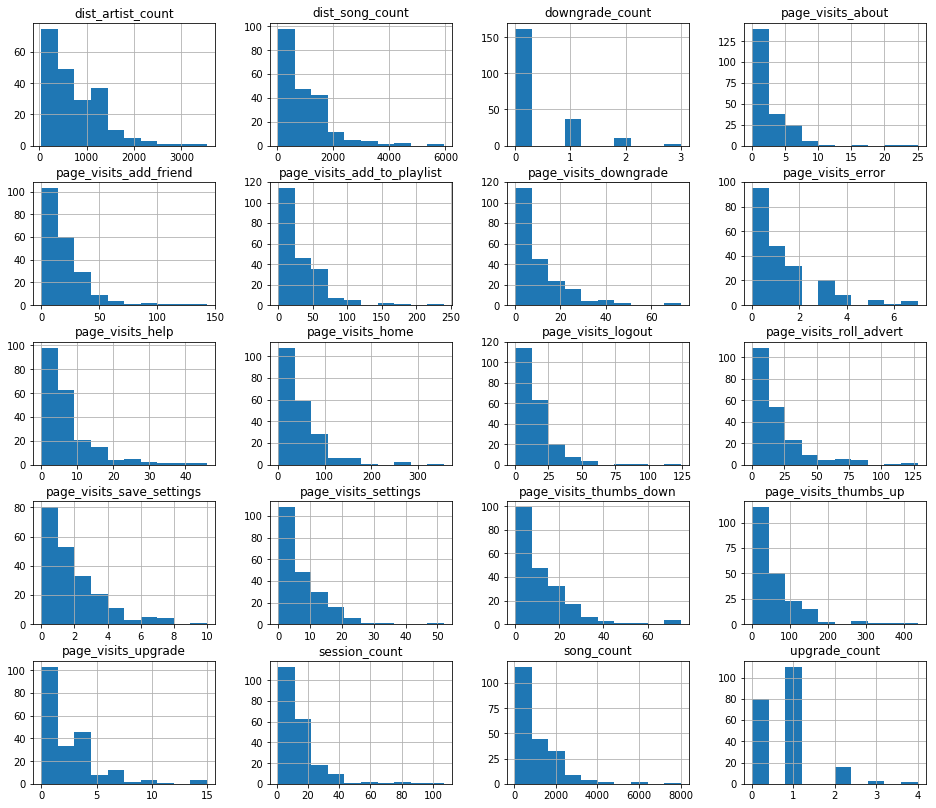

In [50]:
df_churn.drop(columns = ['churn']).hist(figsize = (16,14))

Let's rescale the statistics with the number of sessions.

In [51]:
df_div = df_churn.copy(deep = True)
df_div.iloc[:,1:4] = df_div.iloc[:,1:4].div(df_div.session_count, axis=0)
df_div.iloc[:,8:] = df_div.iloc[:,8:].div(df_div.session_count, axis=0)

In [52]:
df_div.describe()

,song_count,dist_song_count,dist_artist_count,session_count,downgrade_count,upgrade_count,churn,page_visits_home,page_visits_logout,page_visits_settings,...,page_visits_thumbs_down,page_visits_thumbs_up,page_visits_upgrade,page_visits_downgrade,page_visits_roll_advert,page_visits_about,page_visits_add_to_playlist,page_visits_add_friend,page_visits_help,page_visits_error
count,211.000000,211.000000,211.000000,211.00000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,...,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000
mean,72.043244,66.232464,54.996462,14.92891,0.298578,0.753555,0.218009,3.234601,1.051545,0.499003,...,0.794146,3.853737,0.199056,0.598534,1.642088,0.162744,1.999003,1.396093,0.449686,0.087725
std,41.417794,36.941480,29.469223,14.76578,0.602335,0.734149,0.413876,1.525071,0.687516,0.420930,...,0.579493,2.237342,0.241285,0.577246,1.829017,0.203898,1.249258,0.883167,0.327990,0.131907
min,10.250000,10.250000,10.250000,1.00000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,...,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.738889,38.541667,33.248248,6.00000,0.000000,0.000000,0.000000,2.142857,0.714286,0.250000,...,0.426407,2.242647,0.040064,0.000000,0.300752,0.000000,1.000000,0.766968,0.246212,0.000000
50%,66.041667,60.500000,49.250000,11.00000,0.000000,1.000000,0.000000,3.000000,1.000000,0.428571,...,0.700000,3.583333,0.142857,0.476190,1.071429,0.125000,1.844828,1.290323,0.400000,0.047619
75%,91.961098,84.850000,67.747826,18.50000,0.000000,1.000000,0.000000,3.932018,1.250000,0.666667,...,1.000000,5.000000,0.276364,0.916084,2.477273,0.232051,2.628289,1.816667,0.594118,0.125000
max,286.666667,246.444444,197.000000,107.00000,3.000000,4.000000,1.000000,11.000000,8.000000,4.000000,...,3.466667,13.777778,2.000000,2.444444,14.000000,2.000000,8.000000,4.666667,2.000000,1.000000


We will use StandardScaler to scale the parameters.

In [53]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
scaler = QuantileTransformer(n_quantiles = 1000, output_distribution = 'uniform')
df_div.iloc[:,1:7] = scaler.fit_transform(df_div.iloc[:,1:7])
df_div.iloc[:,8:] = scaler.fit_transform(df_div.iloc[:,8:])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f66f9efe588>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f66f19f12e8>]], dtype=object)

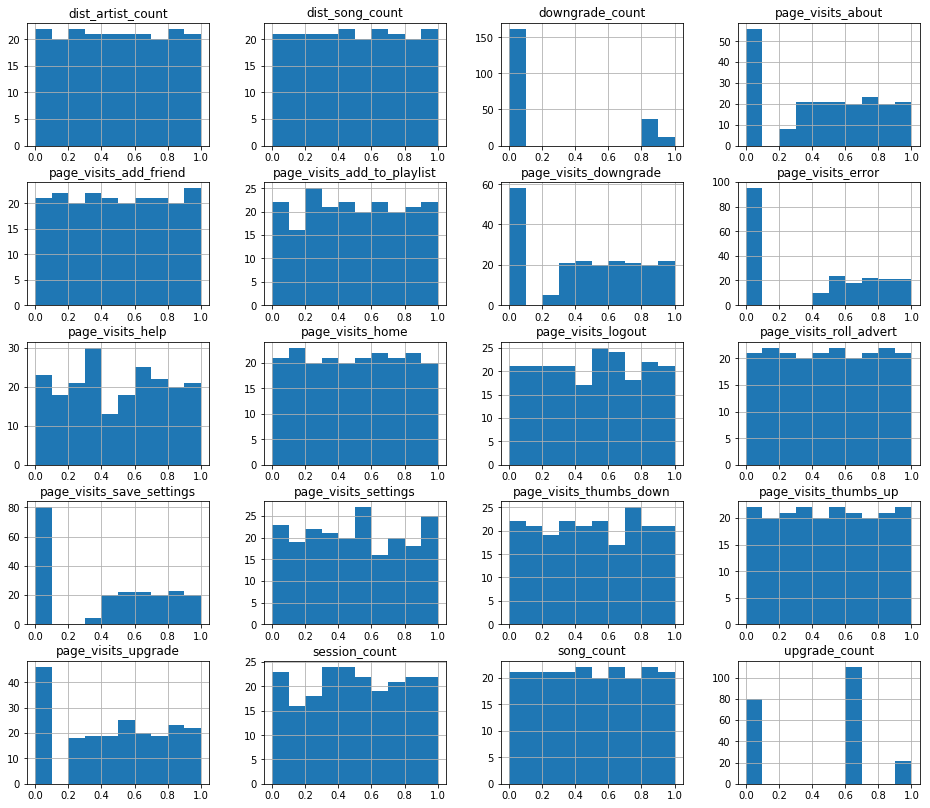

In [54]:
df_div.drop(columns = ['churn']).hist(figsize = (16,14))

In [55]:
df_div.describe()

,song_count,dist_song_count,dist_artist_count,session_count,downgrade_count,upgrade_count,churn,page_visits_home,page_visits_logout,page_visits_settings,...,page_visits_thumbs_down,page_visits_thumbs_up,page_visits_upgrade,page_visits_downgrade,page_visits_roll_advert,page_visits_about,page_visits_add_to_playlist,page_visits_add_friend,page_visits_help,page_visits_error
count,2.110000e+02,2.110000e+02,2.110000e+02,2.110000e+02,2.110000e+02,2.110000e+02,211.000000,2.110000e+02,2.110000e+02,2.110000e+02,...,2.110000e+02,2.110000e+02,2.110000e+02,2.110000e+02,2.110000e+02,2.110000e+02,2.110000e+02,2.110000e+02,2.110000e+02,2.110000e+02
mean,4.999890e-01,4.999995e-01,5.000062e-01,4.996919e-01,2.056560e-01,4.287866e-01,0.218009,5.000080e-01,4.997232e-01,4.943060e-01,...,4.983189e-01,5.000105e-01,4.770950e-01,4.627445e-01,4.969105e-01,4.652525e-01,4.999564e-01,4.987365e-01,4.942798e-01,3.993524e-01
std,2.907290e-01,2.907313e-01,2.907326e-01,2.910068e-01,3.756292e-01,3.478958e-01,0.413876,2.906957e-01,2.908303e-01,2.995560e-01,...,2.934511e-01,2.907200e-01,3.228376e-01,3.372508e-01,2.957166e-01,3.346957e-01,2.907645e-01,2.927962e-01,2.995798e-01,3.811742e-01
min,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,0.000000,1.000000e-07,1.000000e-07,1.000000e-07,...,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07
25%,2.501012e-01,2.499478e-01,2.498456e-01,2.262262e-01,1.000000e-07,1.000000e-07,0.000000,2.502503e-01,2.502503e-01,2.497497e-01,...,2.510052e-01,2.500869e-01,2.498745e-01,1.000000e-07,2.499288e-01,1.000000e-07,2.167167e-01,2.501151e-01,2.559076e-01,1.000000e-07
50%,4.996663e-01,4.995841e-01,4.997366e-01,5.165165e-01,1.000000e-07,6.406406e-01,0.000000,5.240240e-01,5.355355e-01,5.070070e-01,...,5.025025e-01,5.002555e-01,5.025025e-01,4.974975e-01,5.001124e-01,4.974975e-01,4.999827e-01,4.998364e-01,5.025025e-01,5.025025e-01
75%,7.497637e-01,7.511496e-01,7.498585e-01,7.510010e-01,1.000000e-07,6.406406e-01,0.000000,7.499274e-01,7.427427e-01,7.502503e-01,...,7.217217e-01,7.452452e-01,7.488403e-01,7.500634e-01,7.511099e-01,7.500733e-01,7.500981e-01,7.487487e-01,7.523139e-01,7.572573e-01
max,9.999999e-01,9.999999e-01,9.999999e-01,9.999999e-01,9.999999e-01,9.999999e-01,1.000000,9.999999e-01,9.999999e-01,9.999999e-01,...,9.999999e-01,9.999999e-01,9.999999e-01,9.999999e-01,9.999999e-01,9.999999e-01,9.999999e-01,9.999999e-01,9.999999e-01,9.999999e-01


# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

### 1. Supervised learning
Supervised learning algorithms train classifiers based on known input - output pairs. To evaluate the results the data must be split into training and testing data. To comapre different models we will use validation data.

In [56]:
# the number of users is low and the number of those who churned even lower
# let's repeat the splitting as long as we don't have at least 20% of churned users in both test and validate datasets
train, validate, test = np.split(df_div.sample(frac=1), [int(.6*len(df_div)), int(.8*len(df_div))])
while (len(validate[validate['churn']==1]) < len(df_div[df_div['churn']==1]) // 5) or \
        (len(test[test['churn']==1]) < len(df_div[df_div['churn']==1]) // 5) or \
        (len(test[test['churn']==1]) != len(validate[validate['churn']==1])):
        train, validate, test = np.split(df_div.sample(frac=1), [int(.6*len(df_div)), int(.8*len(df_div))])

In [57]:
X_val = validate.drop(columns = ['userID', 'churn'])
y_val = validate['churn']

X_test = test.drop(columns = ['userID', 'churn'])
y_test = test['churn']

X_train = train.drop(columns = ['userID', 'churn'])
y_train = train['churn']

We are dealing with imbalanced classes here. One way to account for that would be to downsample the majority class. This is  an easy way to balance data, but it also reduces the variability in the majority class and therefore the classifiers may be biased. For this reason we will upsample the minority class in the training data.

In [58]:
X_train = X_train.append(X_train[y_train == 1]).append(X_train[y_train == 1]).append(X_train[y_train == 1])
y_train = y_train.append(y_train[y_train == 1]).append(y_train[y_train == 1]).append(y_train[y_train == 1])

#### 1.1. Decision Tree

In [59]:
from sklearn import tree


In [60]:
tree_clf = tree.DecisionTreeClassifier(random_state=42)
ts = time.time()
tree_clf.fit(X_train, y_train)
tree_train_time = time.time() - ts

In [61]:
ts = time.time()
y_pred_tree = tree_clf.predict(X_test)
tree_predict_time = time.time() - ts

In [62]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

In [63]:
f1_tree = f1_score(y_test, y_pred_tree)
precision_tree = precision_score(y_test, y_pred_tree)
recall_tree = recall_score(y_test, y_pred_tree)
print('Decision tree metrics:\n f1: {}\n precision: {}\n recall: {}'.format(f1_tree, precision_tree, recall_tree))

Decision tree metrics:
 f1: 0.11764705882352941
 precision: 0.125
 recall: 0.1111111111111111


Text(0,0.5,'True')

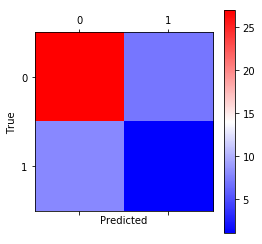

In [64]:
tree_conf_mat = confusion_matrix(y_test, y_pred_tree).astype('float64') 
plt.matshow(tree_conf_mat, cmap=plt.cm.bwr)
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')

#### 1.2. Bagging algorithm: Random Forest
Random Forest creates multiple decision trees and counts their outputs as votes to classify a given data point.

In [65]:
from sklearn.ensemble import RandomForestClassifier

In [66]:
rf_clf = RandomForestClassifier(random_state = 42)
ts = time.time()
rf_clf.fit(X_train, y_train)
rf_train_time = time.time() - ts

In [67]:
ts = time.time()
y_pred_rf = rf_clf.predict(X_test)
rf_predict_time = time.time() - ts

In [68]:
f1_rf = f1_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
print('Random forest metrics:\n f1: {}\n precision: {}\n recall: {}'.format(f1_rf, precision_rf, recall_rf))

Random forest metrics:
 f1: 0.14285714285714285
 precision: 0.2
 recall: 0.1111111111111111


Text(0,0.5,'True')

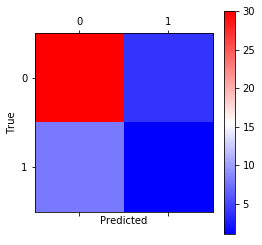

In [69]:
rf_conf_mat = confusion_matrix(y_test, y_pred_rf).astype('float64') 
plt.matshow(rf_conf_mat, cmap=plt.cm.bwr)
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')

#### 1.3. Boosting algorithm: AdaBoost

In [70]:
from sklearn.ensemble import AdaBoostClassifier

In [71]:
ada_clf = AdaBoostClassifier(random_state = 42)
ts = time.time()
ada_clf.fit(X_train, y_train)
ada_train_time = time.time() - ts

In [72]:
ts = time.time()
y_pred_ada = ada_clf.predict(X_test)
ada_predict_time = time.time() - ts

In [73]:
f1_ada = f1_score(y_test, y_pred_ada)
precision_ada = precision_score(y_test, y_pred_ada)
recall_ada = recall_score(y_test, y_pred_ada)
print('AdaBoost metrics:\n f1: {}\n precision: {}\n recall: {}'.format(f1_ada, precision_ada, recall_ada))

AdaBoost metrics:
 f1: 0.13333333333333333
 precision: 0.16666666666666666
 recall: 0.1111111111111111


Text(0,0.5,'True')

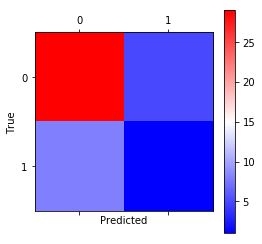

In [74]:
ada_conf_mat = confusion_matrix(y_test, y_pred_ada).astype('float64') 
plt.matshow(ada_conf_mat, cmap=plt.cm.bwr)
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')

#### 1.4. Neural Network: Multi-Layer Perceptron

In [75]:
from sklearn.neural_network import MLPClassifier

In [76]:
mlp_clf = MLPClassifier(hidden_layer_sizes=(7), random_state = 42, early_stopping = True)
ts = time.time()
mlp_clf.fit(X_train, y_train)
mlp_train_time = time.time() - ts

In [77]:
ts = time.time()
y_pred_mlp = mlp_clf.predict(X_test)
mlp_predict_time = time.time() - ts

In [78]:
f1_mlp = f1_score(y_test, y_pred_mlp)
precision_mlp = precision_score(y_test, y_pred_mlp)
recall_mlp = recall_score(y_test, y_pred_mlp)
print('Multi-Layer Perceptron metrics:\n f1: {}\n precision: {}\n recall: {}'.format(f1_mlp, precision_mlp, recall_mlp))

Multi-Layer Perceptron metrics:
 f1: 0.3461538461538462
 precision: 0.20930232558139536
 recall: 1.0


Text(0,0.5,'True')

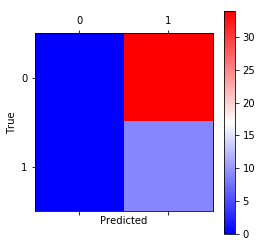

In [79]:
mlp_conf_mat = confusion_matrix(y_test, y_pred_mlp).astype('float64') 
plt.matshow(mlp_conf_mat, cmap=plt.cm.bwr)
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')

#### 1.5. Gaussian Naive Bayes

In [80]:
from sklearn.naive_bayes import GaussianNB

In [81]:
gnb_clf = GaussianNB()
ts = time.time()
gnb_clf.fit(X_train, y_train)
gnb_train_time = time.time() - ts

In [82]:
ts = time.time()
y_pred_gnb = gnb_clf.predict(X_test)
gnb_predict_time = time.time() - ts

In [83]:
f1_gnb = f1_score(y_test, y_pred_gnb)
precision_gnb = precision_score(y_test, y_pred_gnb)
recall_gnb = recall_score(y_test, y_pred_gnb)
print('Gaussian naive bayes metrics:\n f1: {}\n precision: {}\n recall: {}'.format(f1_gnb, precision_gnb, recall_gnb))

Gaussian naive bayes metrics:
 f1: 0.36363636363636365
 precision: 0.25
 recall: 0.6666666666666666


Text(0,0.5,'True')

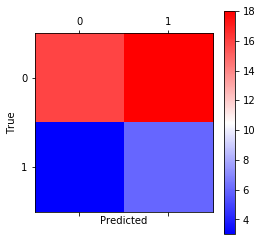

In [84]:
gnb_conf_mat = confusion_matrix(y_test, y_pred_gnb).astype('float64') 
plt.matshow(gnb_conf_mat, cmap=plt.cm.bwr)
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')

#### 1.6. Linear Support Vector Classification

In [85]:
from sklearn.svm import LinearSVC

In [86]:
svc_clf = LinearSVC(random_state = 42, class_weight='balanced')
ts = time.time()
svc_clf.fit(X_train, y_train)
svc_train_time = time.time() - ts

In [87]:
ts = time.time()
y_pred_svc = svc_clf.predict(X_test)
svc_predict_time = time.time() - ts

In [88]:
f1_svc = f1_score(y_test, y_pred_svc)
precision_svc = precision_score(y_test, y_pred_svc)
recall_svc = recall_score(y_test, y_pred_svc)
print('Linear Support Vector Classification metrics:\n f1: {}\n precision: {}\n recall: {}'.format(f1_svc, precision_svc, recall_svc))

Linear Support Vector Classification metrics:
 f1: 0.3636363636363637
 precision: 0.3076923076923077
 recall: 0.4444444444444444


Text(0,0.5,'True')

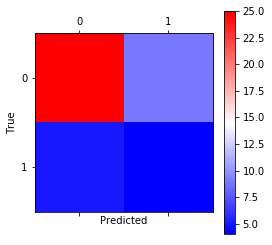

In [89]:
svc_conf_mat = confusion_matrix(y_test, y_pred_svc).astype('float64') 
plt.matshow(svc_conf_mat, cmap=plt.cm.bwr)
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')

#### 1.7. Logistic regression

In [90]:
from sklearn.linear_model import LogisticRegression

In [91]:
lr_clf = LogisticRegression(random_state = 42, class_weight='balanced', solver = 'saga')
ts = time.time()
lr_clf.fit(X_train, y_train)
lr_train_time = time.time() - ts

In [92]:
ts = time.time()
y_pred_lr = lr_clf.predict(X_test)
lr_predict_time = time.time() - ts

In [93]:
f1_lr = f1_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
print('Logistic Regression metrics:\n f1: {}\n precision: {}\n recall: {}'.format(f1_lr, precision_lr, recall_lr))

Logistic Regression metrics:
 f1: 0.3636363636363637
 precision: 0.3076923076923077
 recall: 0.4444444444444444


Text(0,0.5,'True')

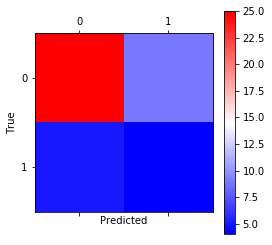

In [94]:
lr_conf_mat = confusion_matrix(y_test, y_pred_lr).astype('float64') 
plt.matshow(lr_conf_mat, cmap=plt.cm.bwr)
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')

In [95]:
y_pred_lr_val = lr_clf.predict(X_val)
y_pred_gnb_val = gnb_clf.predict(X_val)
y_pred_svc_val = svc_clf.predict(X_val)
y_pred_mlp_val = mlp_clf.predict(X_val)

#### 1.8. Selecting the best supervised learning model
We will use validation data to evaluate model predictions once again.

In [96]:
f1_lr_val = f1_score(y_val, y_pred_lr_val)
precision_lr_val = precision_score(y_val, y_pred_lr_val)
recall_lr_val = recall_score(y_val, y_pred_lr_val)
print('Logistic Regression validation metrics:\n f1: {}\n precision: {}\n recall: {}'.format(f1_lr_val, precision_lr_val, recall_lr_val))

Logistic Regression validation metrics:
 f1: 0.5217391304347826
 precision: 0.42857142857142855
 recall: 0.6666666666666666


In [97]:
f1_svc_val = f1_score(y_val, y_pred_svc_val)
precision_svc_val = precision_score(y_val, y_pred_svc_val)
recall_svc_val = recall_score(y_val, y_pred_svc_val)
print('Linear Support Vector validation metrics:\n f1: {}\n precision: {}\n recall: {}'.format(f1_svc_val, precision_svc_val, recall_svc_val))

Linear Support Vector validation metrics:
 f1: 0.5263157894736842
 precision: 0.5
 recall: 0.5555555555555556


In [98]:
f1_mlp_val = f1_score(y_val, y_pred_mlp_val)
precision_mlp_val = precision_score(y_val, y_pred_mlp_val)
recall_mlp_val = recall_score(y_val, y_pred_mlp_val)
print('Multi Layer Perceptron validation metrics:\n f1: {}\n precision: {}\n recall: {}'.format(f1_mlp_val, precision_mlp_val, recall_mlp_val))

Multi Layer Perceptron validation metrics:
 f1: 0.36
 precision: 0.21951219512195122
 recall: 1.0


In [99]:
f1_gnb_val = f1_score(y_val, y_pred_gnb_val)
precision_gnb_val = precision_score(y_val, y_pred_gnb_val)
recall_gnb_val = recall_score(y_val, y_pred_gnb_val)
print('Gaussian Naive Bayes validation metrics:\n f1: {}\n precision: {}\n recall: {}'.format(f1_gnb_val, precision_gnb_val, recall_gnb_val))

Gaussian Naive Bayes validation metrics:
 f1: 0.43478260869565216
 precision: 0.35714285714285715
 recall: 0.5555555555555556


##### Conclusion
Logistic regressions still remains our best model. The F1 score of 0.63 is not exactly high, but we must take in consideration, that we trained the model on a very small part of our dataset. The difference in score between test and validation data shows that the randomization of the subsets can have great impact on the performance metrics in such setup.

### 2. Unsupervised learning.
Unsupervised learning methods do not require labels. Their goal is to discover intrinsic relationships in the data. Such methods can involve dimensionality reduction (Principal Components Analysis) or clustering (K-Means).

#### 2.1. Dimensionality reduction with PCA

The first 10 components explain 91.21% of variance.


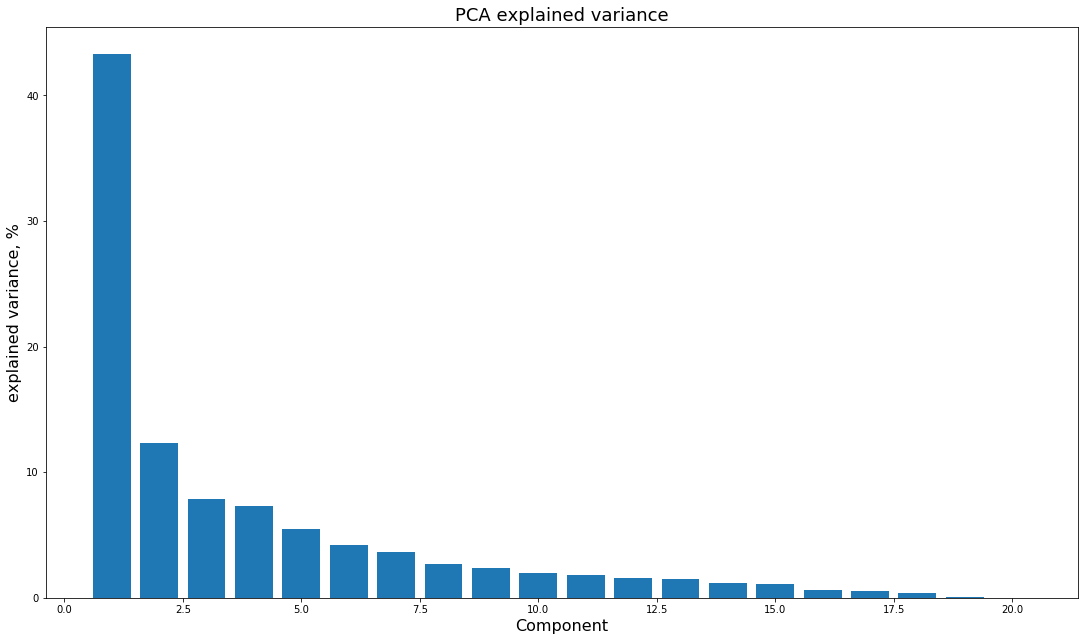

In [100]:
from sklearn.decomposition import PCA

pca = PCA(random_state = 42)
X = df_div.drop(columns = ['userID', 'churn'])
pca.fit(X)
plt.bar(range(1,21), 100*pca.explained_variance_ratio_)
plt.title('PCA explained variance', fontsize = 18)
plt.ylabel('explained variance, %', fontsize = 16)
plt.xlabel('Component', fontsize = 16)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
print('The first 10 components explain {:.2f}% of variance.'.format(100*pca.explained_variance_ratio_[:10].sum()))

In [101]:
pca = PCA(n_components = 10, random_state = 42)
X_pca = pca.fit_transform(X)

#### 2.2. Clustering with K-Means
We will apply K-Means to the transformed data to find the clusters of the users. In the next step we will see if churn can be localized to some of the clusters.

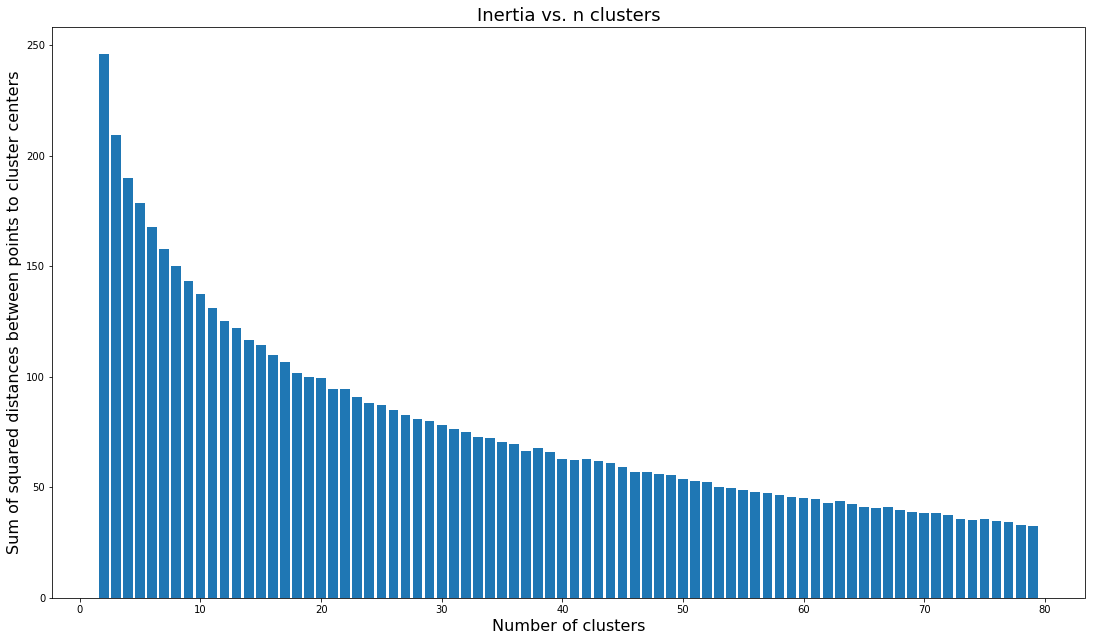

In [102]:
from sklearn.cluster import KMeans

inertia = []

for n_c in range(2,80):
    kmeans = KMeans(n_clusters = n_c, random_state = 42)
    kmeans.fit_predict(X_pca)
    inertia.append(kmeans.inertia_)

plt.bar(range(2,80), inertia)
plt.title('Inertia vs. n clusters', fontsize = 18)
plt.ylabel('Sum of squared distances between points to cluster centers', fontsize = 16)
plt.xlabel('Number of clusters', fontsize = 16)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

Using the elbow method we take 15 clusters.

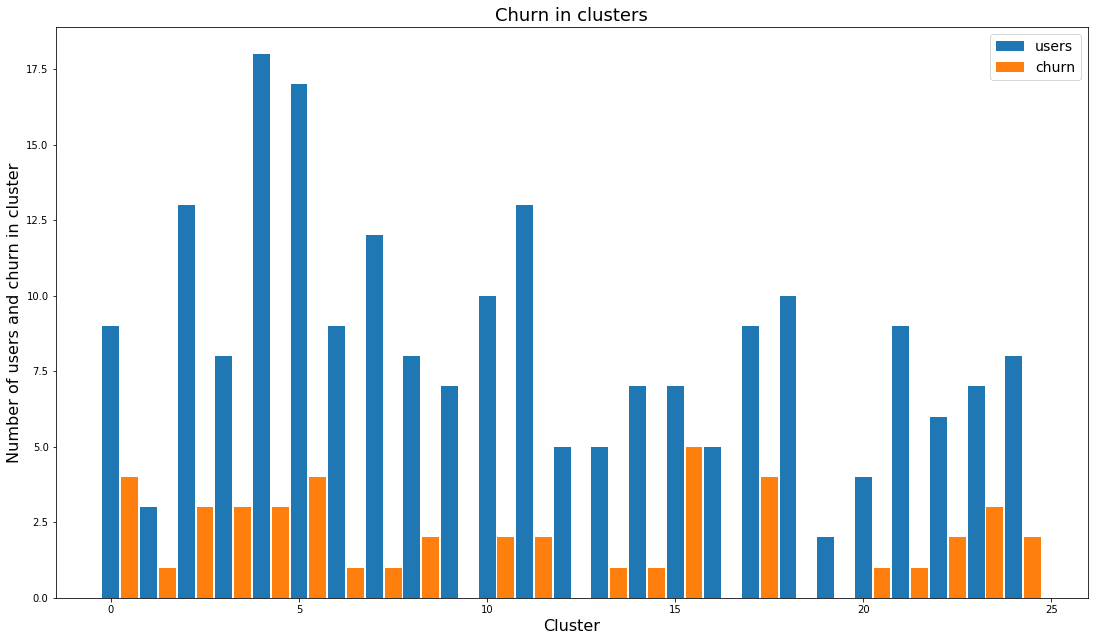

In [114]:
n_c = 25
kmeans = KMeans(n_clusters = n_c, random_state = 42)
labels = kmeans.fit_predict(X_pca).tolist()
df_kmeans = pd.DataFrame.from_dict({'userID':df_div['userID'].tolist(), 'churn':df_div['churn'].tolist(), 'cluster':labels})
plt.bar(np.arange(0,n_c), df_kmeans.groupby('cluster')['churn'].count(), width = 0.45, label = 'users')
plt.bar(np.arange(0,n_c) + 0.5, df_kmeans.groupby('cluster')['churn'].sum().tolist(), width = 0.45, label = 'churn')
plt.title('Churn in clusters', fontsize = 18)
plt.ylabel('Number of users and churn in cluster', fontsize = 16)
plt.xlabel('Cluster', fontsize = 16)
plt.legend(fontsize = 14)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

In [104]:
df_cluster_churn = pd.DataFrame.from_dict({'user count':df_kmeans.groupby('cluster')['churn'].count().tolist(),
                                           'churn count':df_kmeans.groupby('cluster')['churn'].sum()})

In [105]:
df_cluster_churn

,user count,churn count
cluster,,
0,11,3
1,18,5
2,19,3
3,8,2
4,12,5
5,16,3
6,11,0
7,11,3
8,15,1


##### Conclusion
Unfortunately unsupervised learning didn't yield the results we would like to get. Although some clusters have a high percentage of churn we can't find the optimal number of clusters from the small dataset.

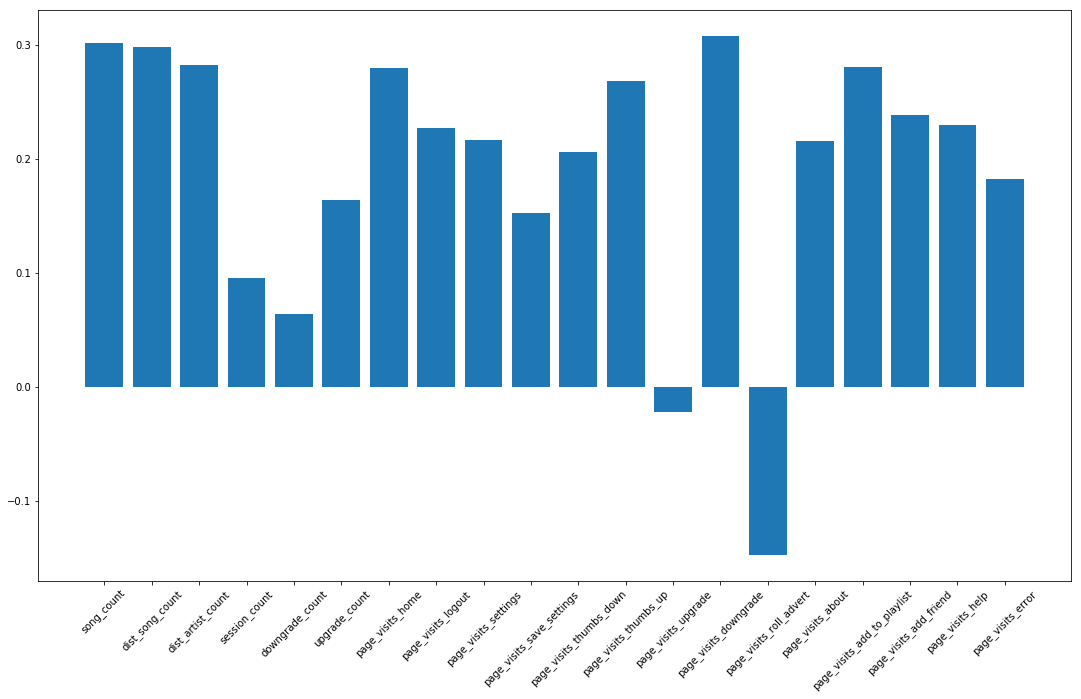

In [106]:
pca = PCA(n_components = 10, random_state = 42)
X_pca = pca.fit_transform(X)

plt.bar(np.arange(0,20),pca.components_[0])
plt.xticks(np.arange(0,20), X.columns, rotation = 45)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

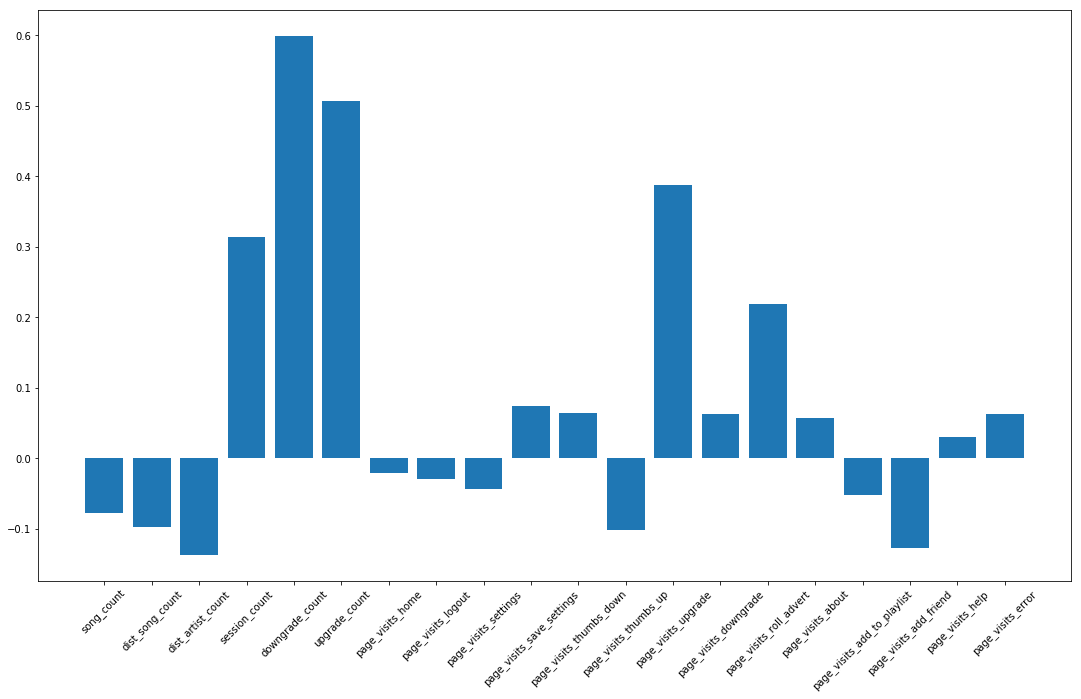

In [107]:
plt.bar(np.arange(0,20),pca.components_[1])
plt.xticks(np.arange(0,20), X.columns, rotation = 45)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

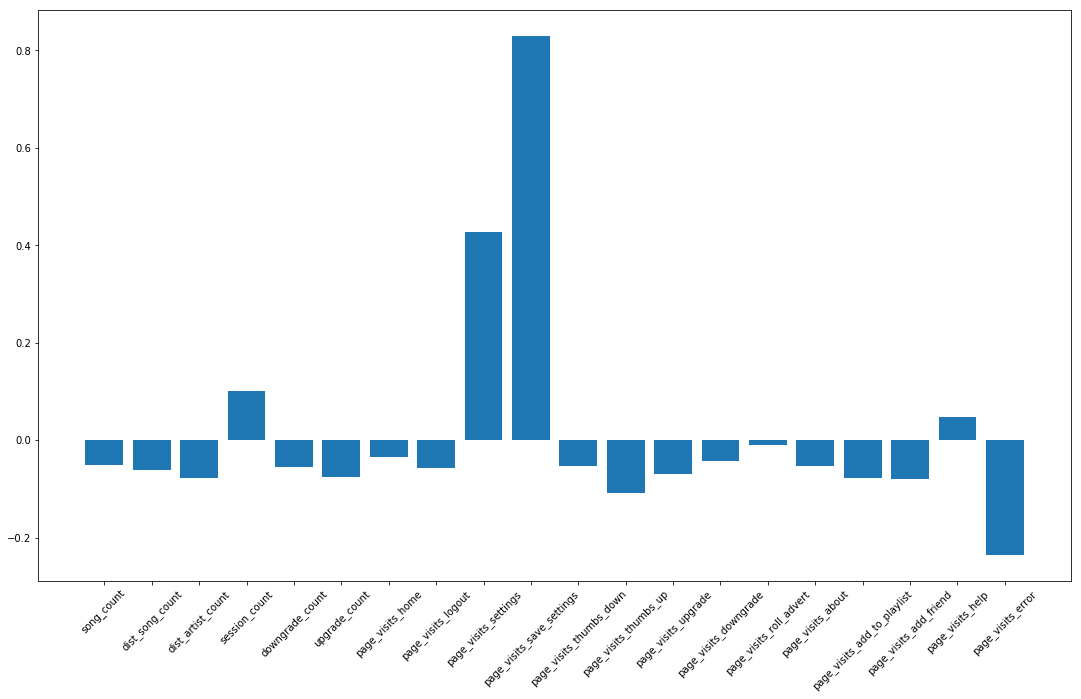

In [108]:
plt.bar(np.arange(0,20),pca.components_[3])
plt.xticks(np.arange(0,20), X.columns, rotation = 45)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

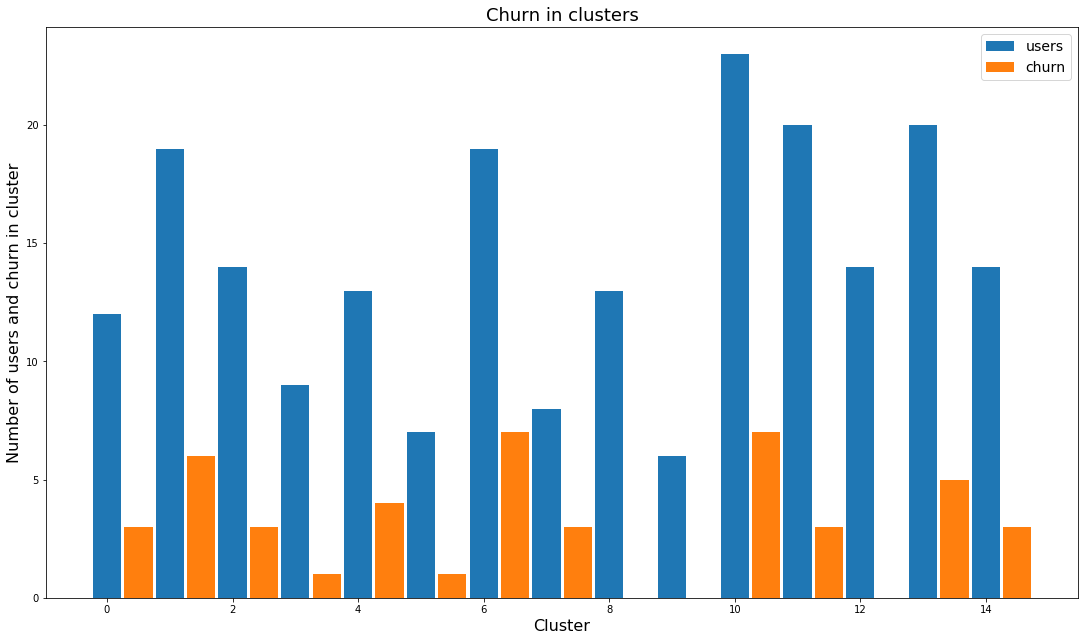

In [109]:
n_c = 15
kmeans = KMeans(n_clusters = n_c)
labels = kmeans.fit_predict(X_pca[:,2:4]).tolist()
df_kmeans = pd.DataFrame.from_dict({'userID':df_div['userID'].tolist(), 'churn':df_div['churn'].tolist(), 'cluster':labels})
plt.bar(np.arange(0,n_c), df_kmeans.groupby('cluster')['churn'].count(), width = 0.45, label = 'users')
plt.bar(np.arange(0,n_c) + 0.5, df_kmeans.groupby('cluster')['churn'].sum().tolist(), width = 0.45, label = 'churn')
plt.title('Churn in clusters', fontsize = 18)
plt.ylabel('Number of users and churn in cluster', fontsize = 16)
plt.xlabel('Cluster', fontsize = 16)
plt.legend(fontsize = 14)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

In [110]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Sparkify.ipynb'])

0